# The Impossible Turn

In general aviation, there's something known as *the impossible turn*.

![turn](./assets/turnback.jpg)

([Image source](https://generalaviationnews.com/2019/05/29/the-impossible-turn-is-now-possible/))

The basic idea is that you are climbing out from a runway, when suddenly your engine dies. You have two options:

1. Land straight ahead in the softest field within your (short) gliding distance

2. Do a 180 degree turn ("The Impossible Turn") and return to the runway, landing downwind.

Option 2 is tempting, because a successful runway landing will likely result in less aircraft damage than a successful off-runway landing.

Despite that, the conventional wisdom is to land straight ahead if possible. This is because the impossible turn typically requires a deceptively large amount of initial altitude to be successful.

In this tutorial, let's quantify just how much altitude this impossible turn requires.

## Geometry

First, we'll use the same Cessna 152 airplane that we worked with in a previous tutorial.

In [1]:
import aerosandbox as asb
import aerosandbox.numpy as np
from aerosandbox.tools import units as u

from cessna152 import airplane  # See cessna152.py for details.

Next, we'll implement our dynamics problem.

Note that this is a 3D dynamics problem. We have a few new state variables as a result:

* "Track": this is the heading of the airplane, in radians. 0 is North, $\pi/2$ is East.
* "Bank": this is the bank angle of the airplane, in radians.

In [2]:
### Initialize the problem
opti = asb.Opti()

### Define time. Note that the horizon length is unknown.
time = np.cosspace(
    0,
    opti.variable(init_guess=60, lower_bound=0),
    100
)
N = np.length(time)

### Create a dynamics instance

dyn = asb.DynamicsPointMass3DSpeedGammaTrack(
    mass_props=asb.MassProperties(mass=1151.8 * u.lbm),
    x_e=opti.variable(
        init_guess=300 * (np.sin(2 * np.pi * np.linspace(0, 0.5, N))) / 2
    ),
    y_e=opti.variable(
        init_guess=300 * (1 - np.cos(2 * np.pi * np.linspace(0, 0.5, N))) / 2
    ),
    z_e=opti.variable(
        np.linspace(-100, 0, N)
    ),
    speed=opti.variable(init_guess=100, n_vars=N),
    gamma=opti.variable(
        init_guess=0, n_vars=N,
        lower_bound=np.radians(-75),
        upper_bound=np.radians(75),
    ),
    track=opti.variable(
        init_guess=np.linspace(0, np.pi, N)
    ),
    alpha=opti.variable(init_guess=5, n_vars=N, lower_bound=-15, upper_bound=15),
    beta=np.zeros(N),
    bank=opti.variable(
        init_guess=np.radians(20), n_vars=N,
        lower_bound=np.radians(-60),
        upper_bound=np.radians(60),
    )
)
# Constrain the initial state
opti.subject_to([
    dyn.x_e[0] == 0,
    dyn.y_e[0] == 0,
    # Note: starting altitude left unconstrained
    dyn.speed[0] == 67 * u.knot,
    dyn.gamma[0] == np.arctan(dyn.altitude[0] / 2000),
    dyn.track[0] == 0,
    # Initial velocity vector points exactly opposite the vector to the airport
    # Note: starting alpha left unconstrained
    dyn.bank[0] == 0,
])

# Constrain the final state
opti.subject_to([
    dyn.x_e[-1] == -2000,
    dyn.y_e[-1] == 0,
    dyn.altitude[-1] == 0,
    # Note: final speed left unconstrained
    dyn.gamma[-1] == 0,
    dyn.track[-1] == np.pi,
    # Note: final alpha left unconstrained
    dyn.bank[-1] == 0,
])  # A soft runway touchdown

# Add some constraints on rate of change of inputs (alpha and bank angle)
pitch_rate = np.diff(dyn.alpha) / np.diff(time)  # deg/sec
roll_rate = np.diff(np.degrees(dyn.bank)) / np.diff(time)  # deg/sec
opti.subject_to([
    pitch_rate > -5,
    pitch_rate < 5,
    roll_rate > -10,
    roll_rate < 10,
])

### Add in forces
dyn.add_gravity_force(g=9.81)

aero = asb.AeroBuildup(
    airplane=airplane,
    op_point=dyn.op_point
).run()

dyn.add_force(
    *aero["F_w"],
    axes="wind"
)

# Add some extra drag to make the trajectory steeper and more interesting
extra_drag = dyn.op_point.dynamic_pressure() * 0.3
dyn.add_force(
    Fx=-extra_drag, axes="wind"
)

### Constrain the altitude to be above ground at all times
opti.subject_to(
    dyn.altitude / 1000 > 0
)

### Finalize the problem
dyn.constrain_derivatives(opti, time)  # Apply the dynamics constraints created up to this point

opti.minimize(dyn.altitude[0] / 1000)  # Minimize the starting altitude

### Solve it
sol = opti.solve()

### Substitute the optimization variables in the dynamics instance with their solved values (in-place)
dyn = sol(dyn)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     5755
Number of nonzeros in inequality constraint Jacobian.:     1889
Number of nonzeros in Lagrangian Hessian.............:     2401

Total number of variables............................:      801
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      606
Total number of inequality constraints...............:     1097
        inequality constraints with only lower bounds:      599
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      498
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e-01 2.00e+03 5.56e-02   0.0 0.00e+00    -  0.00e+00 0.00e+00  

The required initial altitude is:

In [3]:
print(
    "Required initial altitude to make the impossible turn: "
    f"{dyn.altitude[0]:.1f} meters "
    f"({dyn.altitude[0] / u.foot:.1f} feet)"
)
print(f"Assumes the runway is {-dyn.x_e[-1]:.1f} meters ({-dyn.x_e[-1] / u.foot:.1f} feet) behind us.")


Required initial altitude to make the impossible turn: 172.2 meters (564.8 feet)
Assumes the runway is 2000.0 meters (6561.7 feet) behind us.


So - should we do the impossible turn or not?

In a typical climbout with our Cessna 152, we'll be flying roughly at best-climb speed $V_y \approx 67\ \text{kts}$. Spec sheets will tell us that, in ideal conditions at sea level with only the pilot onboard, this gives us a 715 ft/min climb rate.

So, if we're assuming we're 2 km past our takeoff point (which, for simplicity, we assume is the landing point as well), we can compute our likely altitude:

In [4]:
from aerosandbox.tools import units as u

starting_altitude = (2000) * (715 * u.ft / u.min) / (67 * u.knot)
print(f"Starting altitude: {starting_altitude:.1f} meters")

Starting altitude: 210.8 meters


So, we're likely at 211 meters altitude, and we need 194 meters altitude to complete the impossible turn. So, in theory, it's possible - but that's a tight margin! Remember that this assumes perfect piloting, and that the pilot instantly realizes the engine has failed - unlikely.

This is why the impossible turn is generally not recommended.

Cool! Let's visualize:

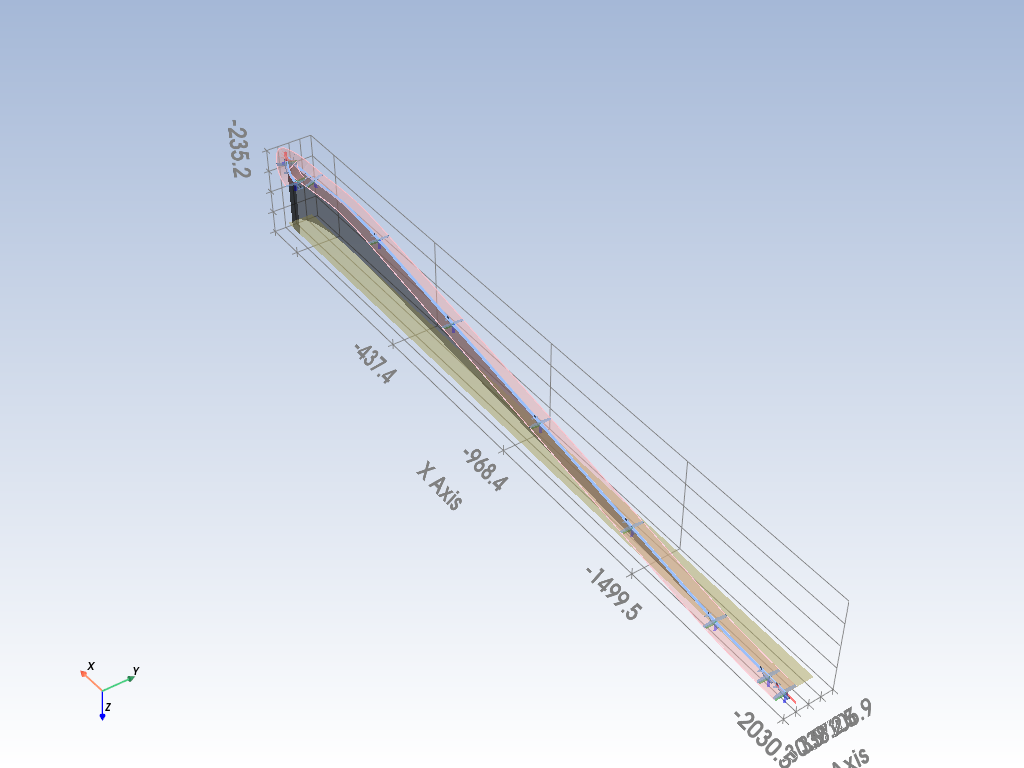

In [11]:
# NBVAL_SKIP

plotter = dyn.draw(
    vehicle_model=airplane,
    scale_vehicle_model=6,  # Draw the vehicle at 6x scale
    show=False
)
plotter.camera.elevation = 15  # Increase the elevation angle by 15 degrees
plotter.camera.azimuth = 100
plotter.camera.zoom(1.2)
plotter.show(jupyter_backend="static")

Note that we're visualizing the airplane at 6x scale so that the orientation can be seen more easily.

How about we visualize that first turn maneuver? Here's what the first 180-degree turn looks like:

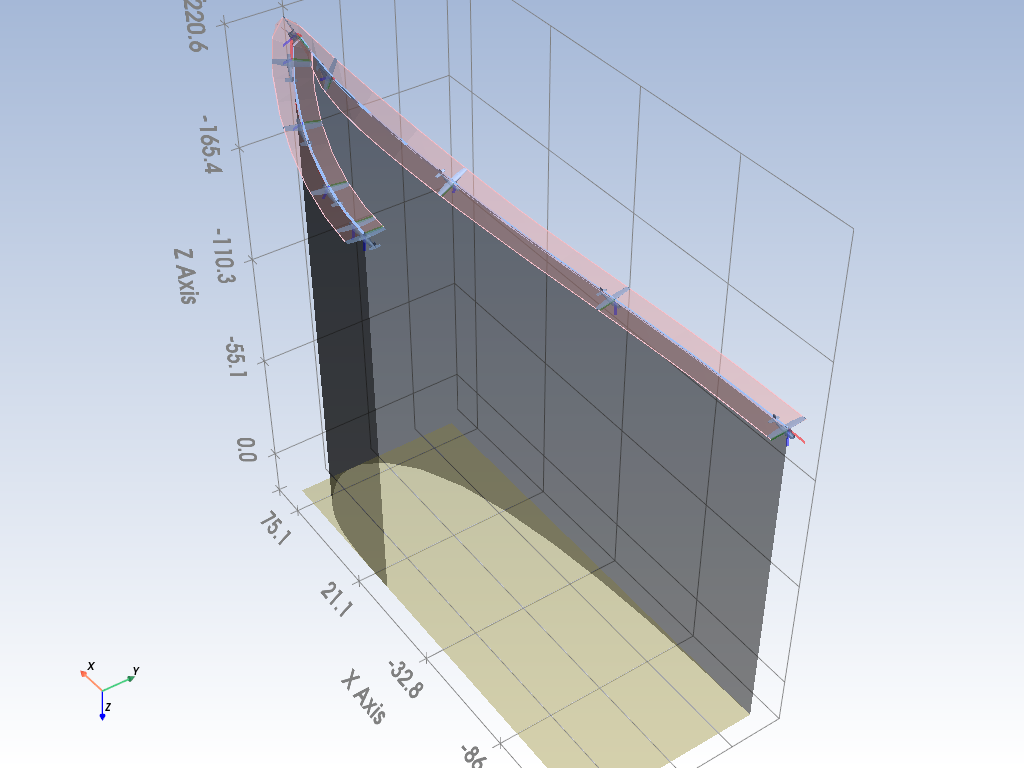

In [10]:
# NBVAL_SKIP

index_of_end_of_first_turn = np.nonzero(dyn.track > np.pi)[0][0]
plotter = dyn[:index_of_end_of_first_turn].draw(
    vehicle_model=airplane,
    scale_vehicle_model=1.5,  # Draw the vehicle at 1.5x scale
    show=False
)
plotter.camera.elevation = 15  # Increase the elevation angle by 15 degrees
plotter.camera.azimuth = 100
plotter.camera.zoom(1.2)
plotter.show(jupyter_backend="static")

Let's make some state variables plots as well:

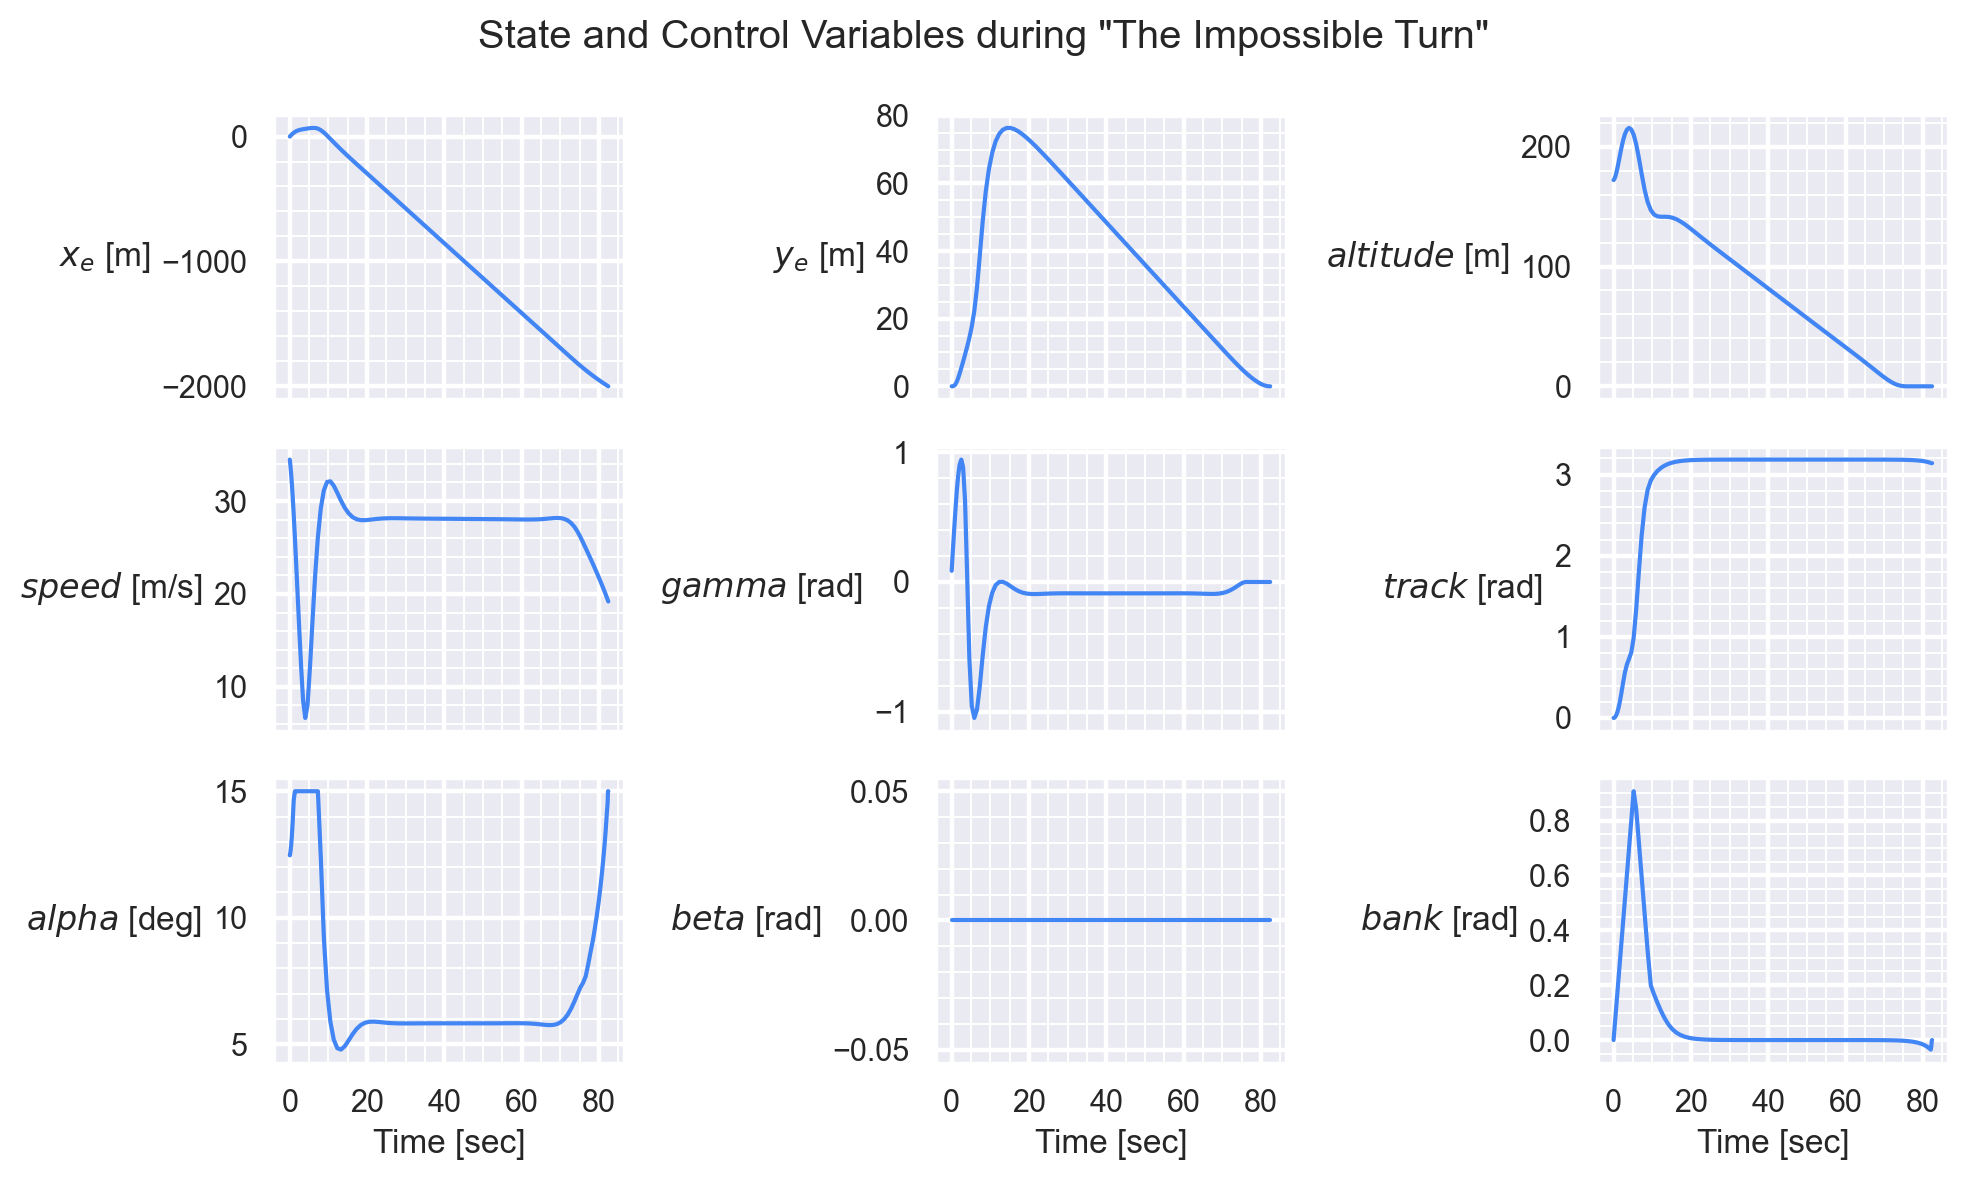

In [7]:
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

fig, ax = plt.subplots(3, 3, figsize=(10, 6), sharex=True)
ax_flattened = list(ax.flatten())
plt.sca(ax[0, 0])


def plot(var_name, unit=""):
    ### Make the plot
    plt.plot(sol.value(time), getattr(dyn, var_name))
    plt.ylabel(f"${var_name}$ [{unit}]")

    ### And go to the next subplot, if applicable
    current_axis_id = ax_flattened.index(plt.gca())
    if not current_axis_id == len(ax_flattened) - 1:
        plt.sca(ax_flattened[current_axis_id + 1])


plot("x_e", "m")
plot("y_e", "m")
plot("altitude", "m")
plot("speed", "m/s")
plot("gamma", "rad")
plot("track", "rad")
plot("alpha", "deg")
plot("beta", "rad")
plot("bank", "rad")

for a in ax[-1, :]:
    plt.sca(a)
    plt.xlabel("Time [sec]")

p.show_plot('State and Control Variables during "The Impossible Turn"')

## Results Interpretation

So what's happening here? Some observations:

* First step: as soon as the engine dies, you should pitch up, hard. This does two things:
    * It takes you from your climb speed $V_y$ to your slower best-glide speed $V_g$.
    * It reduces the speed at which you are going away from the airport, which minimizes your glide distance.
* You should also immediately begin banking into a steep turn.
    * The commanded bank angle here is nearly 1 radian, or 60 degrees. That's a lot!
    * A pilot might ask "Won't this stall the airplane?" The trick is that this 180 degree turn does not occur at level altitude, so your load factor doesn't increase. You're essentially executing a benign version of the [Hammerhead aerobatic maneuver, which never stalls the airplane](https://www.iac.org/legacy/aerobatic-figures).

![hammerhead](./assets/hammerhead.jpg)

[(Image source)](https://www.aopa.org/news-and-media/all-news/2016/may/flight-training-magazine/fly-the-wild-side)

* After executing the turnback, it's about what you'd expect: glide back towards the runway.
* In the final 5 seconds of flight, align yourself with the runway, level out the wings, and land.